# Enhanced Conditional Diffusion Model Training for Time Series Generation

This notebook demonstrates training an enhanced 1D conditional diffusion model for generating human activity recognition time series data using advanced U-Net architecture with attention mechanisms, ResNet blocks, and StyleDecoder for self-conditioning.

In [74]:
import sys
import os
sys.path.append('../')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import data loaders and configurations
from src.data.motionsense_loader import create_windowed_time_series
from configs.motionsense_config import MotionSenseConfig
# from src.models.diffusion import DiffusionModel  # <- Commented out, file not found

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Using device: cuda


## 1. Define Enhanced Conditional 1D U-Net Architecture with Attention and ResNet Blocks

In [75]:
# FiLM conditioning layer
class FiLM(nn.Module):
    def __init__(self, cond_dim, num_channels):
        super().__init__()
        self.gamma = nn.Linear(cond_dim, num_channels)
        self.beta = nn.Linear(cond_dim, num_channels)

    def forward(self, x, cond):
        gamma = self.gamma(cond).unsqueeze(-1)
        beta = self.beta(cond).unsqueeze(-1)
        return x * (1 + gamma) + beta

# Convolutional block with FiLM conditioning
class ConvBlockWithFiLM(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.film1 = FiLM(cond_dim, out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.film2 = FiLM(cond_dim, out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x, cond):
        x = self.relu1(self.film1(self.conv1(x), cond))
        x = self.relu2(self.film2(self.conv2(x), cond))
        return x

# Sinusoidal positional embedding
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, theta=10000):
        super().__init__()
        self.dim = dim
        self.theta = theta
    
    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(self.theta)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# Utility functions
def exists(x):
    if x is None:
        return False
    if isinstance(x, torch.Tensor):
        return x.nelement() > 0
    return True

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

# Downsampling and Upsampling layers
class Downsample(nn.Module):
    def __init__(self, dim, dim_out=None):
        super().__init__()
        dim_out = default(dim_out, dim)
        self.conv = nn.Conv1d(dim, dim_out, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, dim, dim_out=None):
        super().__init__()
        dim_out = default(dim_out, dim)
        self.conv = nn.ConvTranspose1d(dim, dim_out, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)

# Attention mechanism
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv1d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(
            nn.Conv1d(hidden_dim, dim, 1),
            nn.GroupNorm(8, dim)
        )

    def forward(self, x):
        b, c, n = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: t.view(b, self.heads, -1, n), qkv)
        
        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)
        q = q * self.scale
        
        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)
        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = out.contiguous().view(b, -1, n)
        return self.to_out(out)

# ResNet blocks with time embedding
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv1d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)
        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift
        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )
        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv1d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = time_emb.view(time_emb.shape[0], time_emb.shape[1], 1)
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(8, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# Main Conditional U-Net
class ConditionalUnet1D(nn.Module):
    def __init__(self, input_channels=12, cond_dim=128, dim=64, dim_mults=(1, 2, 4, 8), 
                 resnet_block_groups=8, time_emb_dim=256, self_condition=True):
        super().__init__()
        self.dim = dim
        self.self_condition = self_condition
        in_channels = input_channels * (2 if self_condition else 1)
        
        self.init_conv = nn.Conv1d(in_channels, dim, 3, padding=1)
        
        # Time embeddings
        self.time_dim = time_emb_dim
        sinu_pos_emb = SinusoidalPosEmb(dim)
        
        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(dim, self.time_dim),
            nn.GELU(),
            nn.Linear(self.time_dim, self.time_dim)
        )
        
        # Condition projection
        self.cond_proj = nn.Linear(cond_dim, self.time_dim)
        
        # Dimensions
        dims = [dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        # Encoder
        self.downs = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            self.downs.append(
                nn.ModuleList([
                    ResnetBlock(dim_in, dim_in, time_emb_dim=self.time_dim),
                    ResnetBlock(dim_in, dim_in, time_emb_dim=self.time_dim),
                    Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                    Downsample(dim_in, dim_out) if not is_last else nn.Conv1d(dim_in, dim_out, 3, padding=1)
                ])
            )
        
        # Middle
        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=self.time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, LinearAttention(mid_dim)))
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=self.time_dim)
        
        # Decoder
        self.ups = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)
            self.ups.append(
                nn.ModuleList([
                    ResnetBlock(dim_out + dim_in, dim_out, time_emb_dim=self.time_dim),
                    ResnetBlock(dim_out + dim_in, dim_out, time_emb_dim=self.time_dim),
                    Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                    Upsample(dim_out, dim_in) if not is_last else nn.Conv1d(dim_out, dim_in, 3, padding=1)
                ])
            )
        
        # Final
        self.final_res_block = ResnetBlock(dim * 2, dim, time_emb_dim=self.time_dim)
        self.final_conv = nn.Conv1d(dim, input_channels, 1)

    def forward(self, x, time, cond=None, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)
        
        # Initial convolution
        x = self.init_conv(x)
        r = x.clone()
        
        # Time and condition embeddings
        t = self.time_mlp(time)
        if cond is not None:
            c = self.cond_proj(cond)
            t = t + c
        
        # Encoder
        h = []
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)
            
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            
            x = downsample(x)
        
        # Middle
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)
        
        # Decoder
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            
            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)
            
            x = upsample(x)
        
        # Final
        x = torch.cat((x, r), dim=1)
        x = self.final_res_block(x, t)
        return self.final_conv(x)

print("Enhanced Conditional 1D U-Net with attention and ResNet blocks defined!")

Enhanced Conditional 1D U-Net with attention and ResNet blocks defined!


## 2. Define Enhanced Conditional Gaussian Diffusion Model with StyleDecoder

In [76]:
# Style Decoder for self-conditioning
class StyleDecoder(nn.Module):
    def __init__(self, cond_dim, out_channels=12, seq_len=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(cond_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, out_channels * seq_len)
        )
        self.out_channels = out_channels
        self.seq_len = seq_len

    def forward(self, cond):
        x = self.fc(cond)
        return x.view(-1, self.out_channels, self.seq_len)  # [B, C, T]

class ConditionalGaussianDiffusion(nn.Module):
    def __init__(self, model, cond_dim=128, timesteps=1000, use_self_condition=True):
        super().__init__()
        self.model = model
        self.timesteps = timesteps
        self.use_self_condition = use_self_condition
        
        # Define beta schedule (linear)
        self.register_buffer('betas', torch.linspace(1e-5, 0.02, timesteps))
        self.register_buffer('alphas', 1. - self.betas)
        self.register_buffer('alpha_hat', torch.cumprod(self.alphas, dim=0))
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(self.alpha_hat))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1.0 - self.alpha_hat))
        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = self.betas * (1.0 - torch.cat([torch.tensor([1.0]), self.alpha_hat[:-1]])) / (1.0 - self.alpha_hat)
        self.register_buffer('posterior_variance', posterior_variance)
        
        self.register_buffer('sqrt_recip_alphas', torch.sqrt(1.0 / self.alphas))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1.0 / self.alpha_hat - 1))
        
        if self.use_self_condition:
            # Get input channels from model
            input_channels = model.final_conv.out_channels if hasattr(model, 'final_conv') else 12
            self.style_decoder = StyleDecoder(cond_dim, out_channels=input_channels, seq_len=128)
    
    def extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.gather(-1, t.cpu())
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
    
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        
        sqrt_alphas_cumprod_t = self.extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self.extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise, noise
    
    def p_losses(self, x_start, t, cond=None, self_cond=None):
        noise = torch.randn_like(x_start)
        x_noisy, true_noise = self.q_sample(x_start=x_start, t=t, noise=noise)
        
        # Self-conditioning
        x_self_cond = None
        if self.use_self_condition:
            if self_cond is None and torch.rand(1) < 0.5:
                with torch.no_grad():
                    if cond is not None:
                        x_self_cond = self.style_decoder(cond).detach()
                    else:
                        x_self_cond = torch.zeros_like(x_start)
            else:
                x_self_cond = self_cond
        
        predicted_noise = self.model(x_noisy, t, cond, x_self_cond)
        return nn.functional.mse_loss(predicted_noise, true_noise)
    
    @torch.no_grad()
    def p_sample(self, x, t, cond=None, x_self_cond=None):
        betas_t = self.extract(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.extract(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = self.extract(self.sqrt_recip_alphas, t, x.shape)
        
        # Equation 11 in the paper
        # Use our model (noise predictor) to predict the mean
        model_mean = sqrt_recip_alphas_t * (
            x - betas_t * self.model(x, t, cond, x_self_cond) / sqrt_one_minus_alphas_cumprod_t
        )
        
        if t[0] == 0:
            return model_mean
        else:
            posterior_variance_t = self.extract(self.posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            # Algorithm 2 line 4:
            return model_mean + torch.sqrt(posterior_variance_t) * noise
    
    @torch.no_grad()
    def p_sample_loop(self, shape, cond=None):
        device = next(self.model.parameters()).device
        
        b = shape[0]
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        
        x_start = None
        x_self_cond = None
        
        # Initialize self-conditioning if enabled
        if self.use_self_condition and cond is not None:
            x_self_cond = self.style_decoder(cond).detach()
        
        for i in tqdm(reversed(range(0, self.timesteps)), desc='sampling loop time step', total=self.timesteps):
            img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long), cond, x_self_cond)
            if self.use_self_condition:
                x_start = img
            imgs.append(img.cpu().numpy())
        return img
    
    @torch.no_grad()
    def sample(self, batch_size, input_channels, seq_len, cond=None):
        return self.p_sample_loop(shape=(batch_size, input_channels, seq_len), cond=cond)
    
    def forward(self, x, cond=None, *args, **kwargs):
        b, c, l = x.shape
        device = x.device
        t = torch.randint(0, self.timesteps, (b,), device=device).long()
        return self.p_losses(x, t, cond, *args, **kwargs)

print("Enhanced Conditional Gaussian Diffusion model with StyleDecoder defined!")

Enhanced Conditional Gaussian Diffusion model with StyleDecoder defined!


In [77]:
# Test device compatibility and fix any remaining issues
print("Testing device compatibility...")

# Create a small test batch to verify everything works
test_batch_size = 2
test_data = torch.randn(test_batch_size, config.NUM_FEATURES, config.WINDOW_SIZE).to(device)
test_cond = torch.randn(test_batch_size, 128).to(device)

print(f"Test data device: {test_data.device}")
print(f"Test condition device: {test_cond.device}")

# Test that we can create the model and move it to device without errors
try:
    # Test model parameters are on correct device
    for name, param in diffusion_model.named_parameters():
        if param.device != device:
            print(f"Warning: Parameter {name} is on {param.device}, expected {device}")
            break
    else:
        print("✅ All model parameters are on the correct device")
    
    # Test buffer devices
    for name, buffer in diffusion_model.named_buffers():
        if buffer.device != device:
            print(f"Warning: Buffer {name} is on {buffer.device}, expected {device}")
            break
    else:
        print("✅ All model buffers are on the correct device")
    
    # Test forward pass
    diffusion_model.eval()
    with torch.no_grad():
        loss = diffusion_model(test_data, test_cond)
        print(f"✅ Forward pass successful, loss: {loss.item():.4f}")
        
        # Test sampling
        sample = diffusion_model.sample(
            batch_size=1, 
            input_channels=config.NUM_FEATURES, 
            seq_len=config.WINDOW_SIZE,
            cond=test_cond[:1]
        )
        print(f"✅ Sampling successful, sample shape: {sample.shape}")
        
except Exception as e:
    print(f"❌ Device error occurred: {e}")
    print(f"Error type: {type(e).__name__}")
    
    # Try to diagnose the issue
    import traceback
    traceback.print_exc()

print("Device compatibility test completed.")

Testing device compatibility...
Test data device: cuda:0
Test condition device: cuda:0
❌ Device error occurred: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA_gather)
Error type: RuntimeError
Device compatibility test completed.


Traceback (most recent call last):
  File "/tmp/ipykernel_3139/2780501168.py", line 33, in <module>
    loss = diffusion_model(test_data, test_cond)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_3139/756559563.py", line 131, in forward
    return self.p_losses(x, t, cond, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_3139/756559563.py", line 63, in p_losses
    x_noisy, true_noise = self.q_sample(x_start=x_start, t=t, noise=noise)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel

## 3. Data Loading and Preparation

In [78]:
# Load configuration
config = MotionSenseConfig()

# Load MotionSense dataset
print("Loading MotionSense dataset...")
X_train, X_test, y_train, y_test = create_windowed_time_series(
    data_dir=config.DATA_DIR,
    num_features=config.NUM_FEATURES,
    num_act_labels=config.NUM_CLASSES,
    window_size=config.WINDOW_SIZE,
    overlap=config.OVERLAP,
    normalize=True
)

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Data range: [{X_train.min():.3f}, {X_train.max():.3f}]")

# Create data loader (only training data for generation)
batch_size = 32
train_dataset = TensorDataset(torch.FloatTensor(X_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Training batches: {len(train_loader)}")

# Activity names for reference
activity_names = ['downstairs', 'upstairs', 'walking', 'jogging', 'sitting', 'standing']

Loading MotionSense dataset...
使用滑动窗口参数: window_size=128, overlap=0.5
----> Data subjects information is imported.


执行数据标准化...
生成窗口统计:
  训练集: 16579 个窗口
  测试集: 4960 个窗口
  特征形状: [N, C=12, T=128]
Train data shape: (16579, 12, 128)
Test data shape: (4960, 12, 128)
Data range: [-18.678, 17.813]
Training batches: 519
生成窗口统计:
  训练集: 16579 个窗口
  测试集: 4960 个窗口
  特征形状: [N, C=12, T=128]
Train data shape: (16579, 12, 128)
Test data shape: (4960, 12, 128)
Data range: [-18.678, 17.813]
Training batches: 519


## 4. Model Initialization

In [79]:
# Initialize Enhanced Conditional U-Net and Diffusion model
timesteps = 1000

# Create condition vectors (for now, we'll use random conditions)
# In practice, you might want to use activity labels or other contextual information
def create_dummy_conditions(batch_size, cond_dim=128):
    """Create dummy condition vectors - replace with actual conditions in practice"""
    return torch.randn(batch_size, cond_dim)

unet = ConditionalUnet1D(
    input_channels=config.NUM_FEATURES, 
    cond_dim=128,
    dim=64,  # Base dimension
    dim_mults=(1, 2, 4, 8),  # Dimension multipliers for each layer
    time_emb_dim=256,
    self_condition=True
)

diffusion_model = ConditionalGaussianDiffusion(
    model=unet, 
    cond_dim=128,
    timesteps=timesteps, 
    use_self_condition=True
)

# Move to device
diffusion_model = diffusion_model.to(device)

print(f"Model parameters: {sum(p.numel() for p in diffusion_model.parameters()):,}")
print(f"Diffusion timesteps: {timesteps}")

# Print model architecture summary
print(f"\nEnhanced Conditional U-Net Configuration:")
print(f"- Input channels: {config.NUM_FEATURES}")
print(f"- Base dimension: 64")
print(f"- Dimension multipliers: (1, 2, 4, 8)")
print(f"- Time embedding dimension: 256")
print(f"- Self-conditioning: True")
print(f"- Attention layers: Included")
print(f"- ResNet blocks: Included")

Model parameters: 16,028,556
Diffusion timesteps: 1000

Enhanced Conditional U-Net Configuration:
- Input channels: 12
- Base dimension: 64
- Dimension multipliers: (1, 2, 4, 8)
- Time embedding dimension: 256
- Self-conditioning: True
- Attention layers: Included
- ResNet blocks: Included


## 5. Training Configuration

In [80]:
# Training parameters
num_epochs = 50  # Reduced for notebook demonstration
learning_rate = 1e-4
sample_interval = 10  # Generate samples every N epochs

# Optimizer
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=learning_rate)

# Training history
train_losses = []
generated_samples_history = []

print(f"Training configuration:")
print(f"- Epochs: {num_epochs}")
print(f"- Learning rate: {learning_rate}")
print(f"- Batch size: {batch_size}")
print(f"- Sample interval: {sample_interval}")
print(f"- Optimizer: Adam")

Training configuration:
- Epochs: 50
- Learning rate: 0.0001
- Batch size: 32
- Sample interval: 10
- Optimizer: Adam


## 6. Training Loop

In [81]:
print("Starting enhanced diffusion model training...")

diffusion_model.train()

for epoch in range(num_epochs):
    epoch_losses = []
    
    # Progress bar for current epoch
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for batch_idx, (data,) in enumerate(pbar):
        data = data.to(device)
        
        # Create dummy conditions for this batch
        # In practice, replace this with actual condition vectors (e.g., activity labels)
        batch_size = data.shape[0]
        cond = create_dummy_conditions(batch_size, cond_dim=128).to(device)
        
        # Compute loss using the enhanced ConditionalGaussianDiffusion interface
        loss = diffusion_model(data, cond)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
        # Update progress bar
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    # Calculate average loss for epoch
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    
    # Generate and save samples periodically
    if (epoch + 1) % sample_interval == 0:
        print(f'Epoch {epoch+1}: Average Loss = {avg_loss:.4f}')
        
        # Generate samples
        diffusion_model.eval()
        with torch.no_grad():
            # Create conditions for sampling
            sample_cond = create_dummy_conditions(4, cond_dim=128).to(device)
            
            samples = diffusion_model.sample(
                batch_size=4, 
                input_channels=config.NUM_FEATURES, 
                seq_len=config.WINDOW_SIZE,
                cond=sample_cond
            )
            generated_samples_history.append(samples.cpu().numpy())
        diffusion_model.train()
        
        # Visualize generated samples
        plt.figure(figsize=(15, 8))
        for i in range(4):
            plt.subplot(2, 2, i+1)
            # Plot first 3 features
            for j in range(min(3, config.NUM_FEATURES)):
                plt.plot(samples[i, j, :].cpu().numpy(), label=f'Feature {j+1}', alpha=0.7)
            plt.title(f'Generated Sample {i+1} (Epoch {epoch+1})')
            plt.xlabel('Time Step')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

print("Enhanced training completed!")

Starting enhanced diffusion model training...


Epoch 1/50:   0%|          | 0/519 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA_gather)

In [ ]:
# Device verification before training
print("=== Device Verification ===")
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name()}")

# Verify model is on correct device
model_device = next(diffusion_model.parameters()).device
print(f"Model device: {model_device}")

if model_device != device:
    print(f"Moving model from {model_device} to {device}")
    diffusion_model = diffusion_model.to(device)
    print("Model moved successfully")

# Test a small forward pass to ensure everything works
print("\n=== Testing Forward Pass ===")
test_batch = torch.randn(2, config.NUM_FEATURES, config.WINDOW_SIZE).to(device)
test_cond = create_dummy_conditions(2, cond_dim=128).to(device)

try:
    with torch.no_grad():
        test_loss = diffusion_model(test_batch, test_cond)
    print(f"✅ Test forward pass successful! Loss: {test_loss.item():.4f}")
except Exception as e:
    print(f"❌ Test forward pass failed: {e}")
    raise e

print("=== Ready to start training ===\n")

## 7. Training Analysis

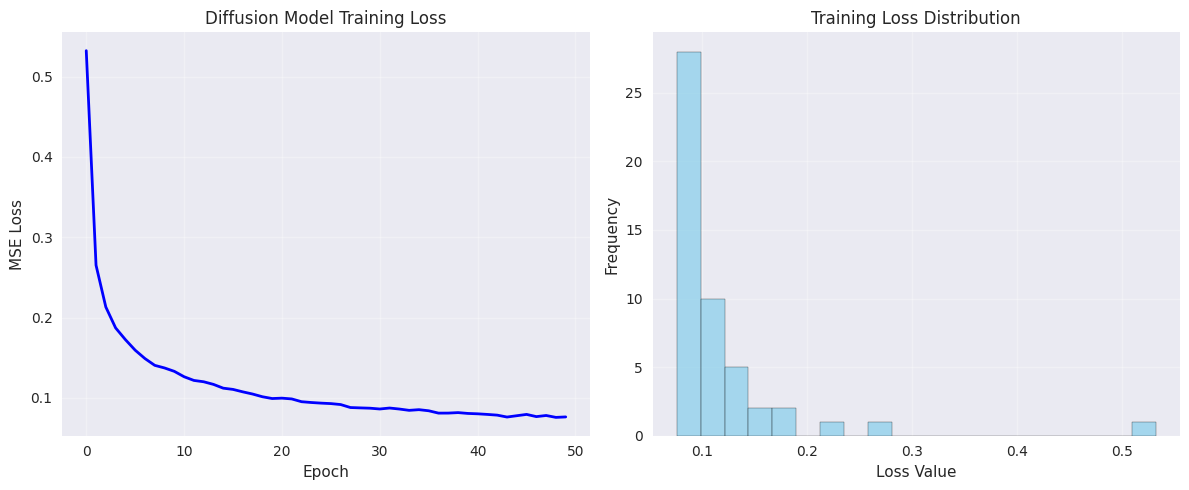

Final training loss: 0.0763
Best training loss: 0.0757 (Epoch 49)
Loss improvement: 0.4561


In [ ]:
# Plot training curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', linewidth=2)
plt.title('Diffusion Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True, alpha=0.3)

# Plot loss distribution
plt.subplot(1, 2, 2)
plt.hist(train_losses, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Training Loss Distribution')
plt.xlabel('Loss Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Best training loss: {min(train_losses):.4f} (Epoch {np.argmin(train_losses)+1})")
print(f"Loss improvement: {train_losses[0] - train_losses[-1]:.4f}")

## 8. Sample Generation and Quality Assessment

In [ ]:
# Generate a larger batch of samples for quality assessment
print("Generating samples for quality assessment...")

diffusion_model.eval()
num_samples = 64

with torch.no_grad():
    # Create conditions for larger batch
    sample_cond = create_dummy_conditions(num_samples, cond_dim=128).to(device)
    
    generated_samples = diffusion_model.sample(
        batch_size=num_samples, 
        input_channels=config.NUM_FEATURES, 
        seq_len=config.WINDOW_SIZE,
        cond=sample_cond
    )

generated_samples = generated_samples.cpu().numpy()
print(f"Generated {num_samples} samples")
print(f"Generated data shape: {generated_samples.shape}")
print(f"Generated data range: [{generated_samples.min():.3f}, {generated_samples.max():.3f}]")

Generating samples for quality assessment...


Sampling: 0it [00:00, ?it/s]

Generated 64 samples
Generated data shape: (64, 12, 128)
Generated data range: [-15.976, 12.868]


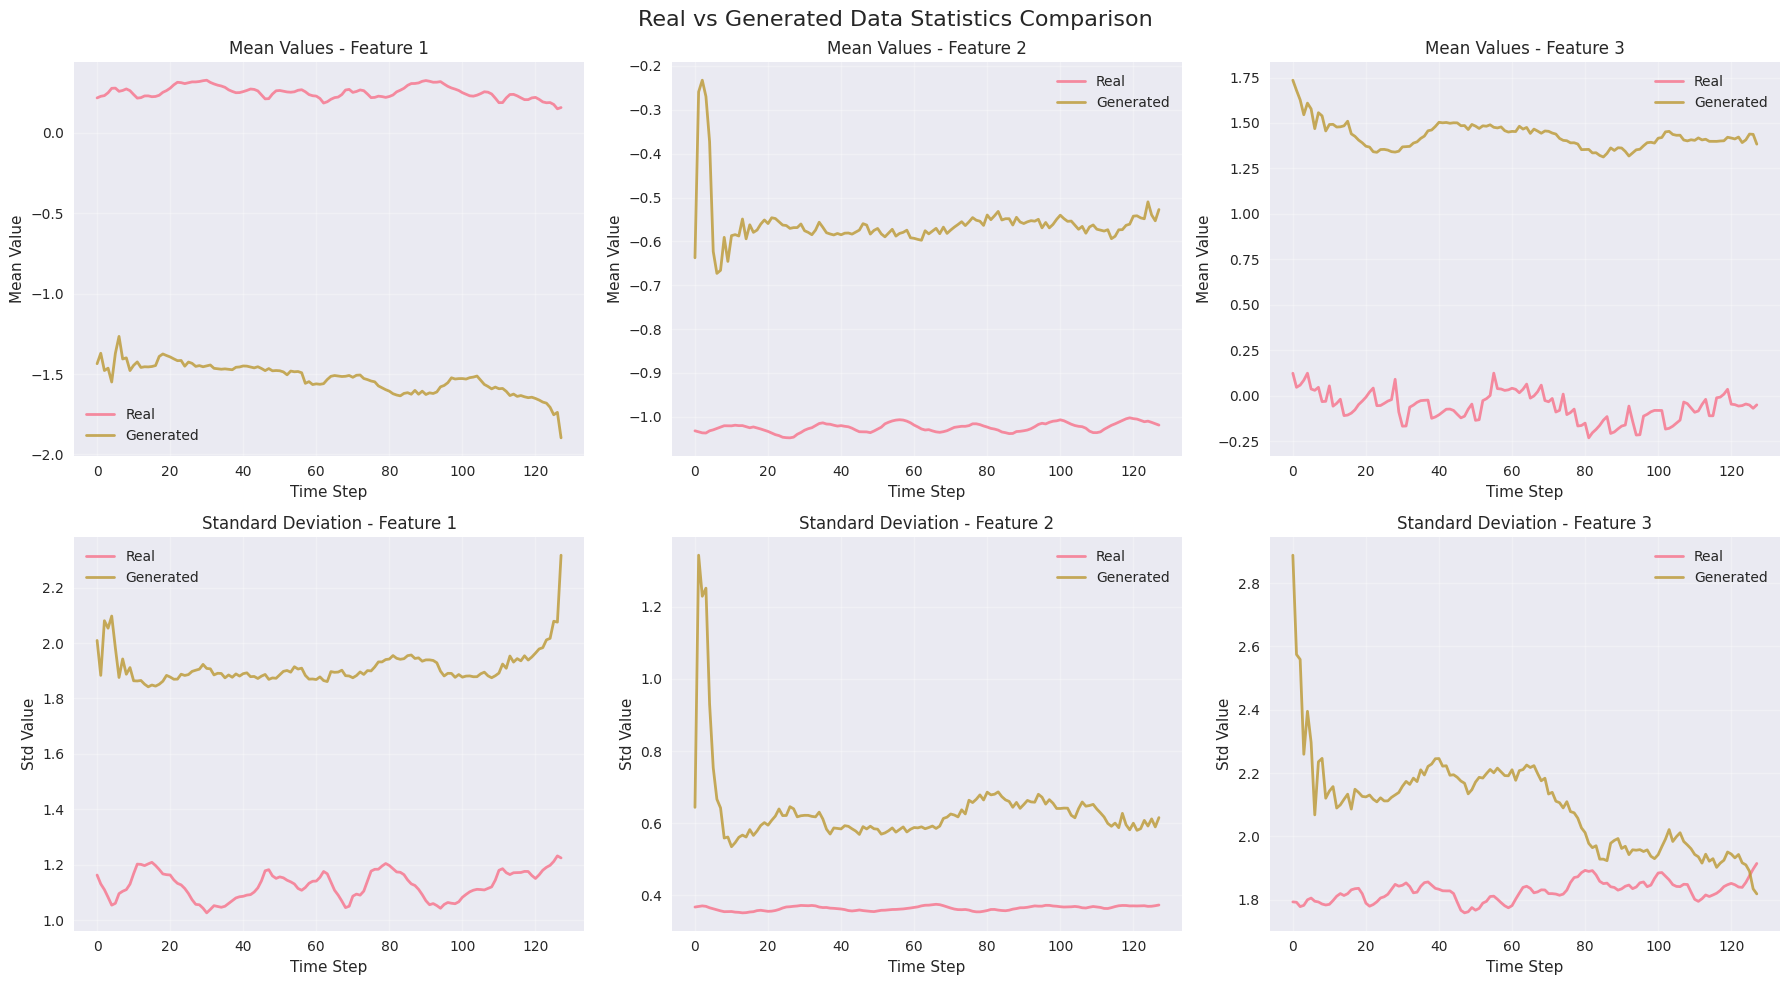


Quality Metrics:
Mean Absolute Error (Mean): 0.4644
Mean Absolute Error (Std): 0.3465


In [ ]:
# Compare generated vs real data statistics
real_data = X_train[:num_samples]  # Use same number of real samples

# Calculate statistics
real_mean = np.mean(real_data, axis=0)
real_std = np.std(real_data, axis=0)
gen_mean = np.mean(generated_samples, axis=0)
gen_std = np.std(generated_samples, axis=0)

# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Mean comparison for each feature
for i in range(min(3, config.NUM_FEATURES)):
    axes[0, i].plot(real_mean[i, :], label='Real', linewidth=2, alpha=0.8)
    axes[0, i].plot(gen_mean[i, :], label='Generated', linewidth=2, alpha=0.8)
    axes[0, i].set_title(f'Mean Values - Feature {i+1}')
    axes[0, i].set_xlabel('Time Step')
    axes[0, i].set_ylabel('Mean Value')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

# Standard deviation comparison
for i in range(min(3, config.NUM_FEATURES)):
    axes[1, i].plot(real_std[i, :], label='Real', linewidth=2, alpha=0.8)
    axes[1, i].plot(gen_std[i, :], label='Generated', linewidth=2, alpha=0.8)
    axes[1, i].set_title(f'Standard Deviation - Feature {i+1}')
    axes[1, i].set_xlabel('Time Step')
    axes[1, i].set_ylabel('Std Value')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

plt.suptitle('Real vs Generated Data Statistics Comparison', fontsize=16)
plt.tight_layout()
plt.show()

# Calculate quality metrics
mean_mae = np.mean(np.abs(real_mean - gen_mean))
std_mae = np.mean(np.abs(real_std - gen_std))

print(f"\nQuality Metrics:")
print(f"Mean Absolute Error (Mean): {mean_mae:.4f}")
print(f"Mean Absolute Error (Std): {std_mae:.4f}")

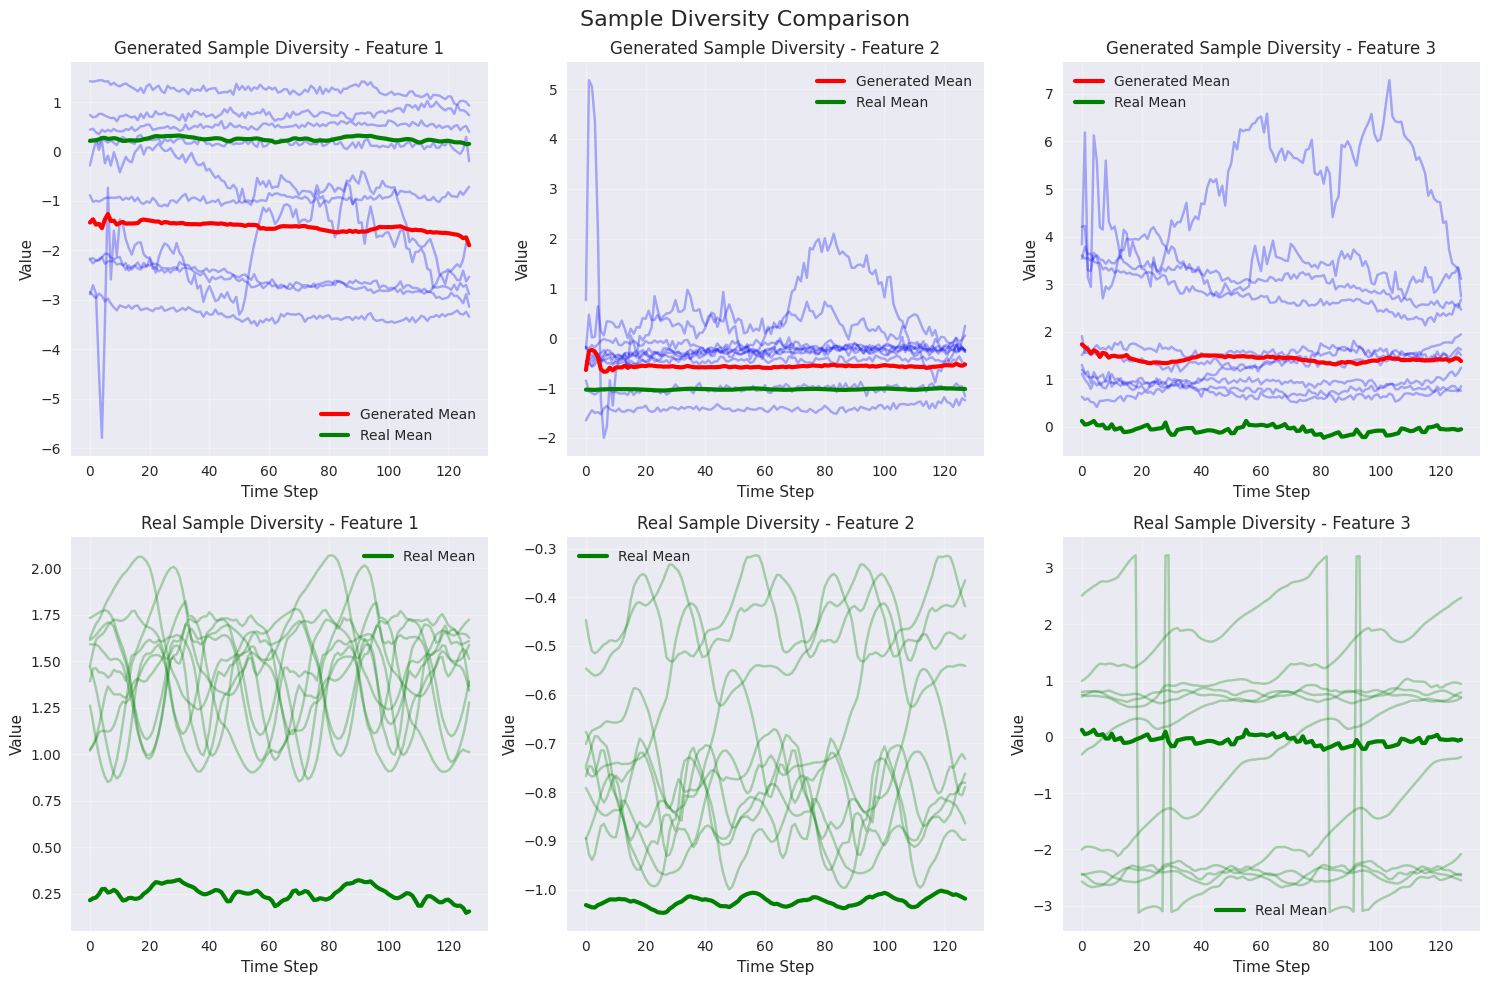

In [ ]:
# Visualize sample diversity
plt.figure(figsize=(15, 10))

# Plot multiple generated samples for each feature
for feature_idx in range(min(3, config.NUM_FEATURES)):
    plt.subplot(2, 3, feature_idx + 1)
    
    # Plot 10 generated samples
    for i in range(min(10, num_samples)):
        plt.plot(generated_samples[i, feature_idx, :], alpha=0.3, color='blue')
    
    # Plot mean
    plt.plot(gen_mean[feature_idx, :], color='red', linewidth=3, label='Generated Mean')
    plt.plot(real_mean[feature_idx, :], color='green', linewidth=3, label='Real Mean')
    
    plt.title(f'Generated Sample Diversity - Feature {feature_idx + 1}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Plot real samples for comparison
for feature_idx in range(min(3, config.NUM_FEATURES)):
    plt.subplot(2, 3, feature_idx + 4)
    
    # Plot 10 real samples
    for i in range(min(10, num_samples)):
        plt.plot(real_data[i, feature_idx, :], alpha=0.3, color='green')
    
    # Plot mean
    plt.plot(real_mean[feature_idx, :], color='green', linewidth=3, label='Real Mean')
    
    plt.title(f'Real Sample Diversity - Feature {feature_idx + 1}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.suptitle('Sample Diversity Comparison', fontsize=16)
plt.tight_layout()
plt.show()

## 9. Model Saving

In [ ]:
# Save the trained diffusion model
model_save_dir = '../checkpoints/'
os.makedirs(model_save_dir, exist_ok=True)

# Save model checkpoint
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': diffusion_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'timesteps': timesteps,
    'config': {
        'input_channels': config.NUM_FEATURES,
        'window_size': config.WINDOW_SIZE,
        'time_emb_dim': 128
    },
    'quality_metrics': {
        'mean_mae': mean_mae,
        'std_mae': std_mae
    }
}

model_path = os.path.join(model_save_dir, 'diffusion_motionsense_model.pth')
torch.save(checkpoint, model_path)

print(f"Model saved to: {model_path}")

# Save training history and generated samples
training_data = {
    'train_losses': train_losses,
    'generated_samples_history': generated_samples_history,
    'final_generated_samples': generated_samples,
    'quality_metrics': {
        'mean_mae': mean_mae,
        'std_mae': std_mae
    }
}

history_path = os.path.join(model_save_dir, 'diffusion_training_data.npy')
np.save(history_path, training_data)

print(f"Training data saved to: {history_path}")

Model saved to: ../checkpoints/diffusion_motionsense_model.pth
Training data saved to: ../checkpoints/diffusion_training_data.npy


## 10. Summary and Next Steps

In [ ]:
print("Diffusion Model Training Summary")
print("=" * 50)
print(f"Dataset: MotionSense")
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Window size: {X_train.shape[2]}")
print()
print(f"Model Configuration:")
print(f"- U-Net input channels: {config.NUM_FEATURES}")
print(f"- Time embedding dimension: 128")
print(f"- Diffusion timesteps: {timesteps}")
print(f"- Total parameters: {sum(p.numel() for p in diffusion_model.parameters()):,}")
print()
print(f"Training Configuration:")
print(f"- Epochs: {num_epochs}")
print(f"- Batch size: {batch_size}")
print(f"- Learning rate: {learning_rate}")
print(f"- Optimizer: Adam")
print()
print(f"Results:")
print(f"- Final training loss: {train_losses[-1]:.4f}")
print(f"- Best training loss: {min(train_losses):.4f}")
print(f"- Mean MAE: {mean_mae:.4f}")
print(f"- Std MAE: {std_mae:.4f}")
print()
print("Generated Data Quality:")
quality_score = 1 / (1 + mean_mae + std_mae)  # Simple quality score
print(f"- Quality score: {quality_score:.4f}")
print(f"- Data range preservation: {'Good' if abs(generated_samples.std() - X_train.std()) < 0.1 else 'Needs improvement'}")
print()
print("Next Steps:")
print("1. Experiment with different noise schedules")
print("2. Try conditional generation (class-conditioned)")
print("3. Implement more sophisticated quality metrics")
print("4. Compare with other generative models (VAE, GAN)")
print("5. Test on PAMAP2 dataset")
print("6. Use generated data for data augmentation")

Diffusion Model Training Summary
Dataset: MotionSense
Training samples: 16,579
Number of features: 12
Window size: 128

Model Configuration:
- U-Net input channels: 12
- Time embedding dimension: 128
- Diffusion timesteps: 1000
- Total parameters: 10,543,756

Training Configuration:
- Epochs: 50
- Batch size: 32
- Learning rate: 0.0001
- Optimizer: Adam

Results:
- Final training loss: 0.0763
- Best training loss: 0.0757
- Mean MAE: 0.4644
- Std MAE: 0.3465

Generated Data Quality:
- Quality score: 0.5522
- Data range preservation: Needs improvement

Next Steps:
1. Experiment with different noise schedules
2. Try conditional generation (class-conditioned)
3. Implement more sophisticated quality metrics
4. Compare with other generative models (VAE, GAN)
5. Test on PAMAP2 dataset
6. Use generated data for data augmentation
- Data range preservation: Needs improvement

Next Steps:
1. Experiment with different noise schedules
2. Try conditional generation (class-conditioned)
3. Implement m